In [43]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# import DeepEye analysis functions
from deepeye_analysis_package.preprocessing import getFixationLatency, handle_carryover_fixations_and_merge, addAOI
from deepeye_analysis_package.plotting import plot2d

### Function to extract relevant saccades

In [44]:
# Get relevant saccades (one per trial)
def getSaccades(df, fn='', plot=False):
    
    ### Convert columns to numeric ###
    df['FixXPos'] = pd.to_numeric(df['FixXPos'], errors='coerce')
    df['FixYPos'] = pd.to_numeric(df['FixYPos'], errors='coerce')
    df['targetX'] = pd.to_numeric(df['targetX'], errors='coerce')
    df['fixationStimY'] = pd.to_numeric(df['fixationStimY'], errors='coerce')
    df['fixationStimX'] = pd.to_numeric(df['fixationStimX'], errors='coerce')
    df['resX'] = pd.to_numeric(df['resX'], errors='coerce')
    df['resY'] = pd.to_numeric(df['resY'], errors='coerce')
    df['PrevFixXPos'] = pd.to_numeric(df['PrevFixXPos'], errors='coerce')
    df['PrevFixYPos'] = pd.to_numeric(df['PrevFixYPos'], errors='coerce')
    df['PrevFixSampTime'] = pd.to_numeric(df['PrevFixSampTime'], errors='coerce')
    df['DistFromPrevFix'] = pd.to_numeric(df['DistFromPrevFix'], errors='coerce')
    

    ### Get timestamp of when target was presented and add it to the dataframe ###

    # 1) get the first time sample when the target is presented
    sampTime_df = df.drop_duplicates(subset=['trialNr'],  keep='first', ignore_index=True)

    # 2) extract the columns needed
    sampTime_df = sampTime_df[['trialNr', 'sampTime']]

    # 3) rename the columns so they would be added
    sampTime_df.columns = ['trialNr', 'targSampTime']

    # 4) Get only fixations start and end events ###
    fix_events_df = df[df['FixStartEnd'].isin(['fix_start', 'fix_end'])]

    # 5) Merge the target time into the fix_events_df (one time per trial)
    fix_events_df = pd.merge(fix_events_df, sampTime_df, on="trialNr")

    ### Filter the saccades (should end up with max one saccade per trial) ###

    # 1) select only rows where saccade is large
    summary_df = fix_events_df[fix_events_df.DistFromPrevFix > 300]

    # 2) select only rows where the distance between saccade endpoint and target is small
    summary_df['DistEndpoint2Targ'] = summary_df.apply(lambda row: np.linalg.norm(np.array([row.FixXPos, row.FixYPos]) - np.array([row.targetX, row.fixationStimY])), axis=1)
    summary_df = summary_df[summary_df.DistEndpoint2Targ < 150]

    # 3) select only rows where the distance between saccade startpoint and fixation point is small
    summary_df['DistStartpoint2FixPoint'] = summary_df.apply(lambda row: np.linalg.norm(np.array([row.PrevFixXPos, row.PrevFixYPos]) - np.array([row.fixationStimX, row.fixationStimY])), axis=1)
    summary_df = summary_df[summary_df.DistStartpoint2FixPoint < 200]

    # 4) select based on Saccade Latency 
    # Note: Saccade Latency can be negative if the fixation end was not present on the current trial preceding the fixation start
    summary_df['SaccLat'] = summary_df.PrevFixSampTime - summary_df.targSampTime
    # Filter out the trials based on the saccade latency
    summary_df = summary_df[(summary_df.SaccLat > 80) & (summary_df.SaccLat < 600)]
    
    ### Normalize the endpoints to the target on the right ###
    summary_df['NormFixXPos'] = summary_df.apply(
        lambda row: pd.Series([row.resX - row.FixXPos if row.target == 'left' else row.FixXPos]),
        axis=1
    )

    ### Normalize the target position to the target on the right ###
    summary_df['NormtargetX'] = summary_df.apply(
        lambda row: pd.Series([row.resX - row.targetX if row.target == 'left' else row.targetX]),
        axis=1
    )

    ### Normalize the fixation point to the target on the right ###
    summary_df['NormfixationStimX'] = summary_df.apply(
        lambda row: pd.Series([row.resX - row.fixationStimX if row.target == 'left' else row.fixationStimX]),
        axis=1
    )

    # Calculate the mean saccade endpoint for the two conditions
    out = summary_df[summary_df.condition == 'arrowHeadsOutward']
    inw = summary_df[summary_df.condition == 'arrowHeadsInward']

    # Print summary per person
    print(f'Mean Saccade Latency: {summary_df.SaccLat.mean()}')
    print(f'Number of trials: {summary_df.shape[0]}')
    outX = out.NormFixXPos.mean()
    inwX = inw.NormFixXPos.mean()
    print(f'Out: {outX}')
    print(f'Inw: {inwX}')

    if plot == True:
        ### Plot the saccades endpoints ###
        plt.figure()
        plt.title(f'{fn}')        
        out_hndl = plt.scatter(out.NormFixXPos, out.FixYPos, c='blue', alpha=0.5, edgecolors='black')        
        inw_hndl = plt.scatter(inw.NormFixXPos, inw.FixYPos, c='orange', alpha=0.5, edgecolors='black') 

        fixp_hndl = plt.scatter(out.NormfixationStimX, out.fixationStimY, c='red')
        targ_hndl = plt.scatter(out.NormtargetX, out.fixationStimY, c='green')

        plt.legend((out_hndl, inw_hndl, targ_hndl, fixp_hndl), (f'<-> outward arrowheads {np.round(outX,1)}px', f'>-< inward arrowheads {np.round(inwX,1)}px', 'target', 'fixP'), scatterpoints=1)
        plt.xlabel('Horizontal eye position (pixels)')
        plt.ylabel('Vertical eye position (pixels)')       

        # Plot the histogram of saccade latencies
        plt.figure()
        plt.title(f'{fn}')
        h = plt.hist(summary_df.SaccLat)
        plt.xlabel('Saccade Latency (ms)')

    return summary_df
   


### Specify the paths

In [45]:
path = r'C:/Users/aby600/Dropbox/Appliedwork/CognitiveSolutions/Projects/DeepEye/TechnicalReports/TechnicalReport1/Test_MullerLyer/pilot2/complete'
# path = r'D:/Dropbox/Appliedwork/CognitiveSolutions/Projects/DeepEye/TechnicalReports/TechnicalReport1/Test_MullerLyer/pilot3'
path_to_data = os.path.join(path, 'data')
path_to_analysis = os.path.join(path, 'analysis')

### Main Part

Processing participant 2023_09_15_08_42_41...
Mean Saccade Latency: 228.6575757590216
Number of trials: 66
Out: 922.6853041213342
Inw: 928.8187654747795
Processing participant 2023_09_15_08_58_25...
Mean Saccade Latency: 186.4411764697134
Number of trials: 34
Out: 1216.911327940804
Inw: 1247.5307378590785
Processing participant 2023_09_15_09_46_56...
Mean Saccade Latency: 198.76538461790636
Number of trials: 26
Out: 926.4260271505813
Inw: 937.5356252203379


C:\Users\aby600\AppData\Local\Temp\ipykernel_9464\1584227090.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summary_df['DistEndpoint2Targ'] = summary_df.apply(lambda row: np.linalg.norm(np.array([row.FixXPos, row.FixYPos]) - np.array([row.targetX, row.fixationStimY])), axis=1)
C:\Users\aby600\AppData\Local\Temp\ipykernel_9464\1584227090.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summary_df['DistEndpoint2Targ'] = summary_df.apply(lambda row: np.linalg.norm(np.array([row.FixXPos, row.FixYPos])

Processing participant 2023_09_15_11_32_31...
Mean Saccade Latency: 335.20487804856384
Number of trials: 82
Out: 869.777074483622
Inw: 871.913069833805
Processing participant 2023_09_15_12_04_40...
Mean Saccade Latency: 233.66739130473655
Number of trials: 46
Out: 819.5992280702771
Inw: 829.4207873316175
Processing participant 2023_09_15_14_18_29...
Mean Saccade Latency: 316.79999999701977
Number of trials: 1
Out: nan
Inw: 1229.4561486190885


C:\Users\aby600\AppData\Local\Temp\ipykernel_9464\1584227090.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summary_df['DistEndpoint2Targ'] = summary_df.apply(lambda row: np.linalg.norm(np.array([row.FixXPos, row.FixYPos]) - np.array([row.targetX, row.fixationStimY])), axis=1)
C:\Users\aby600\AppData\Local\Temp\ipykernel_9464\1584227090.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summary_df['DistEndpoint2Targ'] = summary_df.apply(lambda row: np.linalg.norm(np.array([row.FixXPos, row.FixYPos])

Processing participant 2023_09_20_10_13_02...
Mean Saccade Latency: 227.34264705879298
Number of trials: 68
Out: 931.5631731448127
Inw: 961.5719182044868
Processing participant 2023_09_20_10_56_22...
Mean Saccade Latency: 325.84444444709357
Number of trials: 9
Out: 801.5345037121187
Inw: 762.8239868053256


C:\Users\aby600\AppData\Local\Temp\ipykernel_9464\1584227090.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summary_df['DistEndpoint2Targ'] = summary_df.apply(lambda row: np.linalg.norm(np.array([row.FixXPos, row.FixYPos]) - np.array([row.targetX, row.fixationStimY])), axis=1)


Combined data saved to C:/Users/aby600/Dropbox/Appliedwork/CognitiveSolutions/Projects/DeepEye/TechnicalReports/TechnicalReport1/Test_MullerLyer/pilot2/complete\analysis\allSubjects_ML.csv
Combined summary data saved to C:/Users/aby600/Dropbox/Appliedwork/CognitiveSolutions/Projects/DeepEye/TechnicalReports/TechnicalReport1/Test_MullerLyer/pilot2/complete\analysis\allSubjects_ML_summary.csv


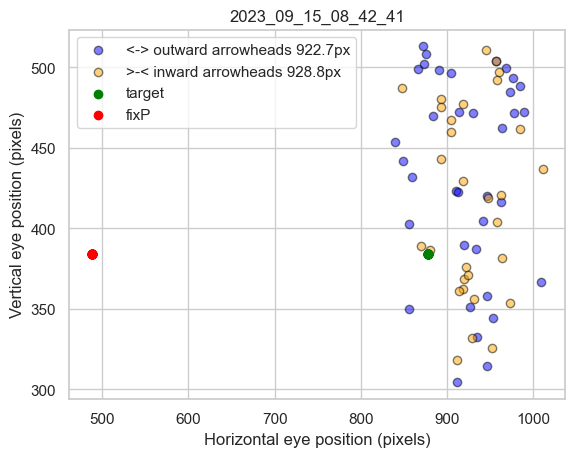

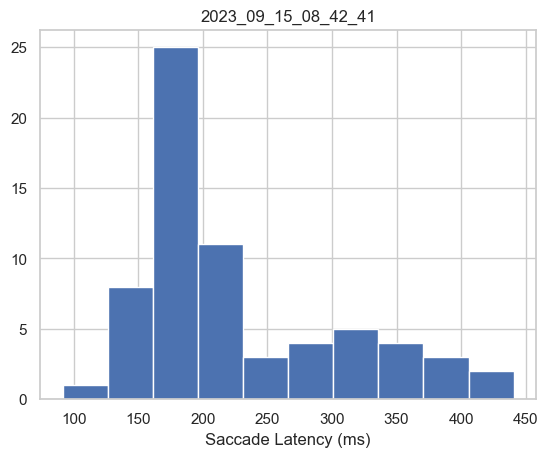

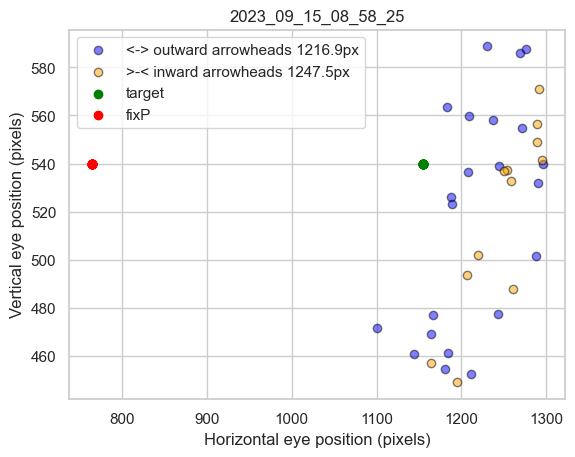

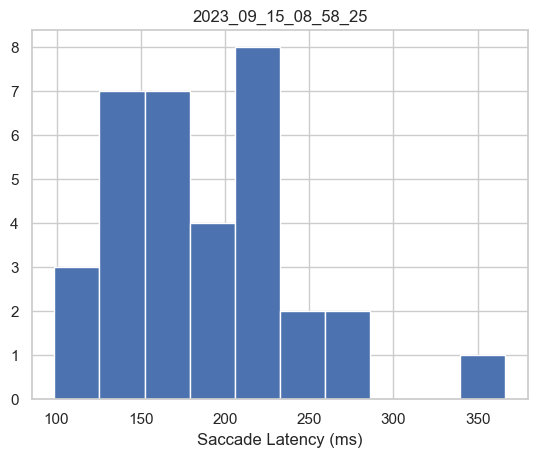

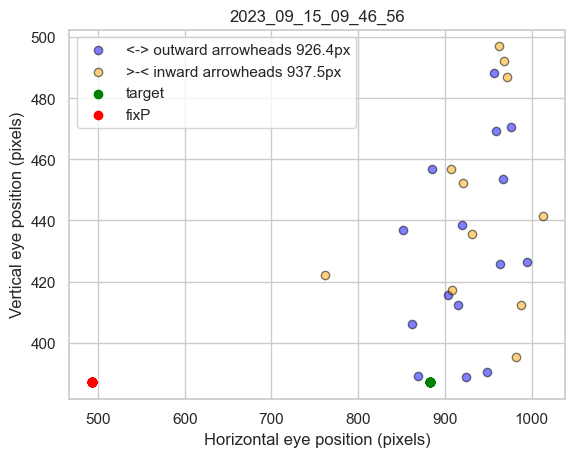

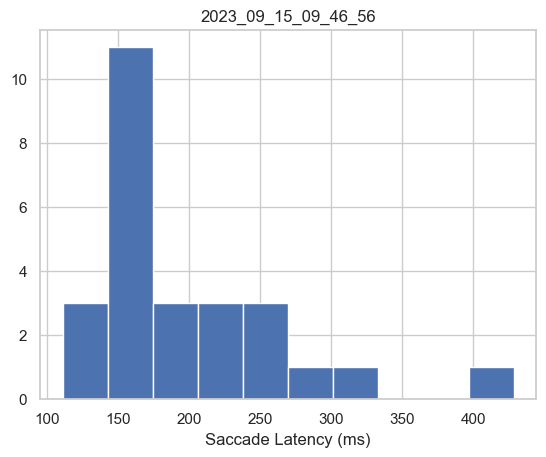

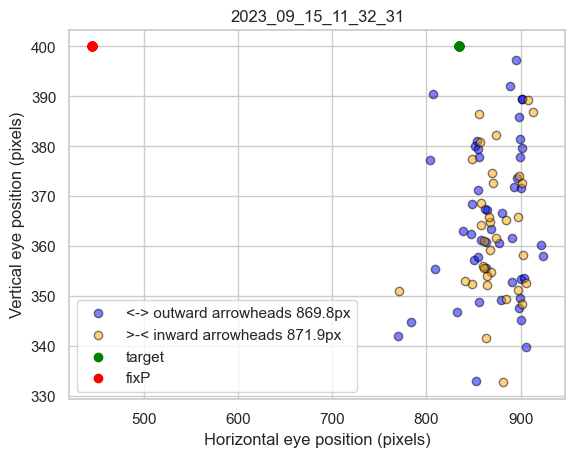

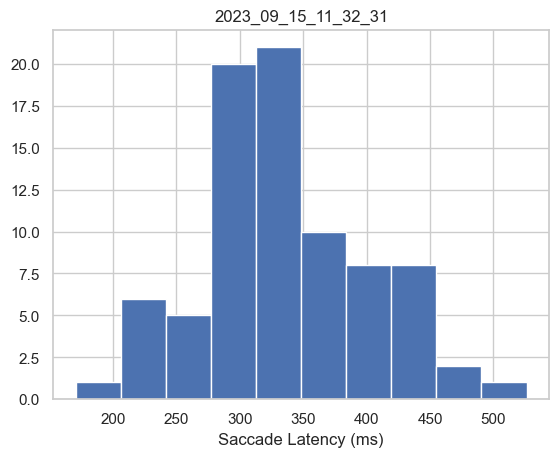

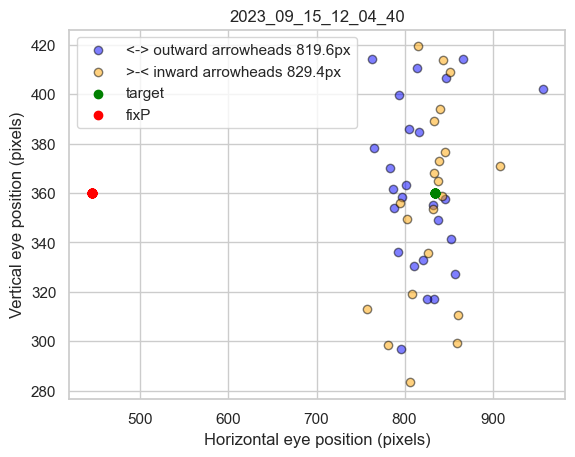

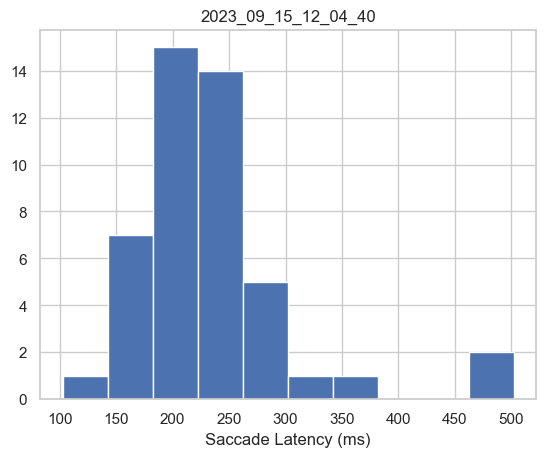

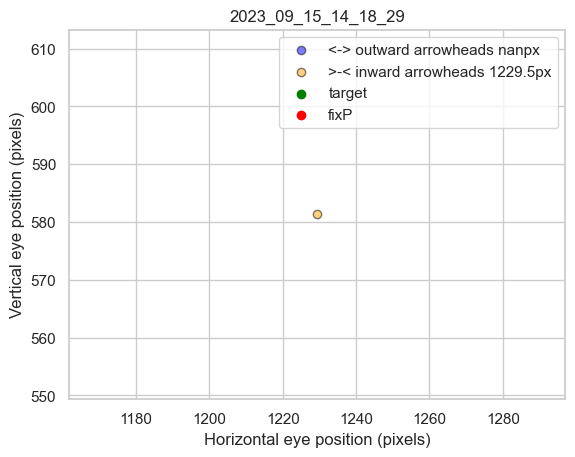

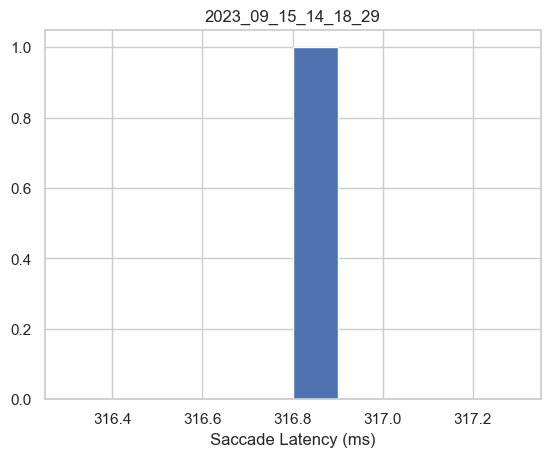

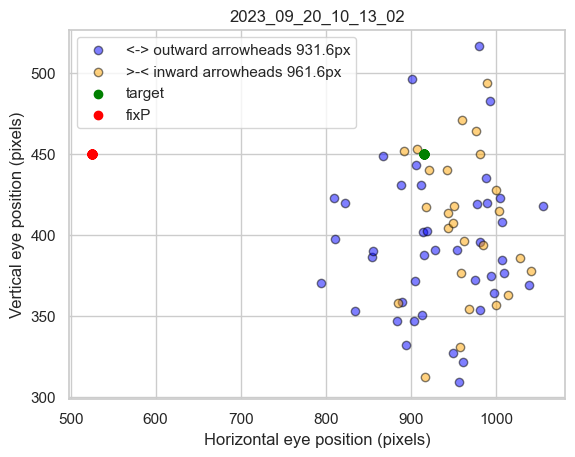

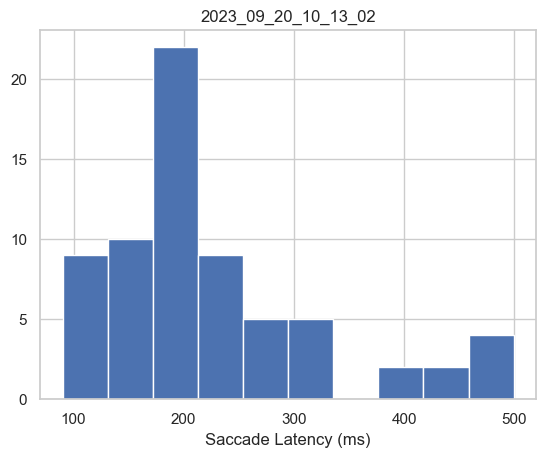

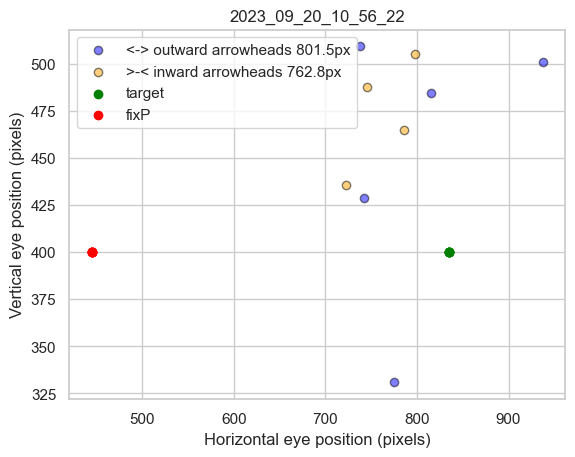

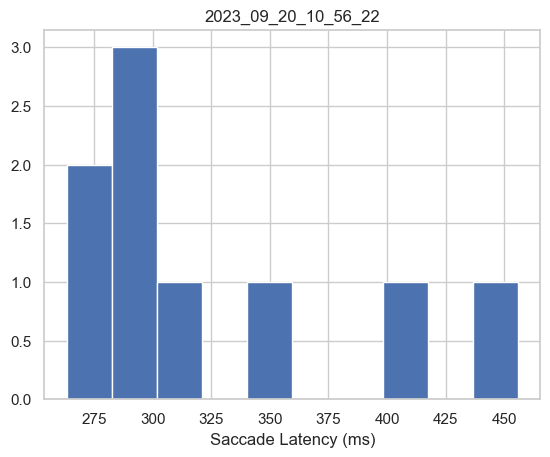

In [46]:
from deepeye_analysis_package.getFixations import extract_fixations

# Initialize an empty list to hold the processed dataframes
output_dfs = []
summary_dfs = []

# Get all folder names from the data directory
folder_names = [name for name in os.listdir(path_to_data) if os.path.isdir(os.path.join(path_to_data, name))]

# Process each participant's data
for fn in folder_names:
    # Check if _record_extra.csv exists, if not use _record.csv
    path_to_file = os.path.join(path_to_data, fn, f'{fn}_record_extra.csv')
    if not os.path.exists(path_to_file):
        path_to_file = os.path.join(path_to_data, fn, f'{fn}_record.csv')

        print(f'Extracting fixations for participant {fn}...')

        try:
            df = pd.read_csv(path_to_file)
            df = extract_fixations(df, path_to_file)
        except FileNotFoundError:
            print(f'File does not exist: {path_to_file}')
            continue    
    else: 
        try:
            df = pd.read_csv(path_to_file)
        except FileNotFoundError:
            print(f'File does not exist: {path_to_file}')
            continue

    print(f'Processing participant {fn}...')
    # Filter data to only include rows where the target was presented
    df1 = df[df['event'] == 'target_on'].copy()

    # Add subject ID to the dataframe
    df1['deepeye_id'] = fn

    # Get saccade endpoint data and latency
    summary_df = getSaccades(df1, fn, plot=True)  
    summary_dfs.append(summary_df)  

    # Accumulate the processed dataframe for this participant
    output_dfs.append(df1)

# Concatenate all participants' data into one DataFrame
if output_dfs:
    output_df = pd.concat(output_dfs, ignore_index=True)
    output_file = os.path.join(path_to_analysis, 'allSubjects_ML.csv')
    output_df.to_csv(output_file, index=False)
    print(f'Combined data saved to {output_file}')
else:
    print('No data was processed.')

# Concatenate all participants' summary data into one DataFrame
if summary_dfs:
    summary_df = pd.concat(summary_dfs, ignore_index=True)
    summary_file = os.path.join(path_to_analysis, 'allSubjects_ML_summary.csv')
    summary_df.to_csv(summary_file, index=False)
    print(f'Combined summary data saved to {summary_file}')
else:
    print('No summary data was processed.')


### Filter subjects with too few datapoints

In [ ]:
# Count the number of data points per 'deepeye_id' and 'condition'
count_df = summary_df.groupby(['condition', 'deepeye_id']).size().reset_index(name='counts')

# Set a threshold for the minimum number of data points per condition
min_data_points = 5  # Adjust this threshold as needed

# Filter out deepeye_ids that don't meet the minimum number of data points
invalid_deepeye_ids = count_df[count_df['counts'] <= min_data_points]['deepeye_id'].unique()

print(f'Excluded subjects based on too few valid trials: {invalid_deepeye_ids}')

# Filter the original DataFrame to exclude the invalid deepeye_ids
filtered_summary_df = summary_df[~summary_df['deepeye_id'].isin(invalid_deepeye_ids)]

### Analyze illusion size

condition           deepeye_id  arrowHeadsInward  arrowHeadsOutward   Illusion
0          2023_09_15_08_42_41        928.818765         922.685304   6.133461
1          2023_09_15_08_58_25       1247.530738        1216.911328  30.619410
2          2023_09_15_09_46_56        937.535625         926.426027  11.109598
3          2023_09_15_11_32_31        871.913070         869.777074   2.135995
4          2023_09_15_12_04_40        829.420787         819.599228   9.821559
5          2023_09_20_10_13_02        961.571918         931.563173  30.008745
T-test: t=2.9838213342786406, p=0.030664652744201753


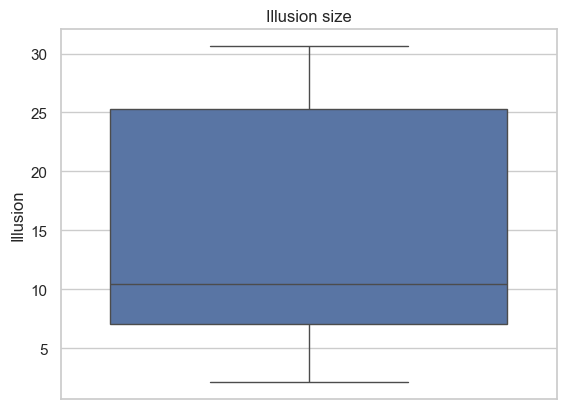

In [64]:
# Summary statistics for the saccade endpoints
illus_df = filtered_summary_df.groupby(['condition', 'deepeye_id'])[['NormFixXPos']].mean().reset_index()

# Pivot the DataFrame to have conditions as columns
illus_df = illus_df.pivot(index='deepeye_id', columns='condition', values='NormFixXPos').reset_index()
illus_df['Illusion'] = illus_df.arrowHeadsInward - illus_df.arrowHeadsOutward

# Drop subjects with NaN values
illus_df = illus_df.dropna()
print(illus_df)

# Plot the illusion size
plt.figure()
plt.title('Illusion size')
sns.boxplot(illus_df.Illusion)

# T-test
from scipy.stats import ttest_rel
t, p = ttest_rel(illus_df.arrowHeadsInward, illus_df.arrowHeadsOutward)
print(f'T-test: t={t}, p={p}')

### Analyze Saccade Latency per subject

condition           deepeye_id  arrowHeadsInward  arrowHeadsOutward  \
0          2023_09_15_08_42_41        233.130000         224.930556   
1          2023_09_15_08_58_25        171.358333         194.668182   
2          2023_09_15_09_46_56        204.136364         194.826667   
3          2023_09_15_11_32_31        345.650000         327.806250   
4          2023_09_15_12_04_40        219.390476         245.660000   
5          2023_09_20_10_13_02        248.823077         214.045238   

condition  IllusionLatency  
0                 8.199444  
1               -23.309848  
2                 9.309697  
3                17.843750  
4               -26.269524  
5                34.777839  
T-test: t=0.3517391999290653, p=0.7393720951179001


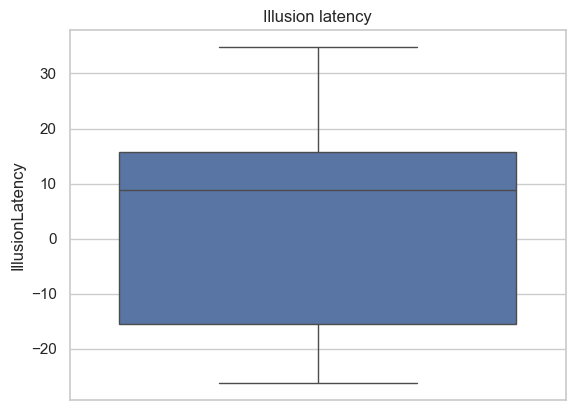

In [65]:
# Summary statistics for the saccade latency
illusLatency_df = filtered_summary_df.groupby(['condition', 'deepeye_id'])[['SaccLat']].mean().reset_index()

# Pivot the DataFrame to have conditions as columns
illusLatency_df = illusLatency_df.pivot(index='deepeye_id', columns='condition', values='SaccLat').reset_index()
illusLatency_df['IllusionLatency'] = illusLatency_df.arrowHeadsInward - illusLatency_df.arrowHeadsOutward
print(illusLatency_df)

# Plot the illusion latency
plt.figure()
plt.title('Illusion latency')
sns.boxplot(illusLatency_df.IllusionLatency)

# T-test
from scipy.stats import ttest_rel
t, p = ttest_rel(illusLatency_df.arrowHeadsInward, illusLatency_df.arrowHeadsOutward)
print(f'T-test: t={t}, p={p}')

### Saccade Latency For all subjects together, for outward and inward arrows

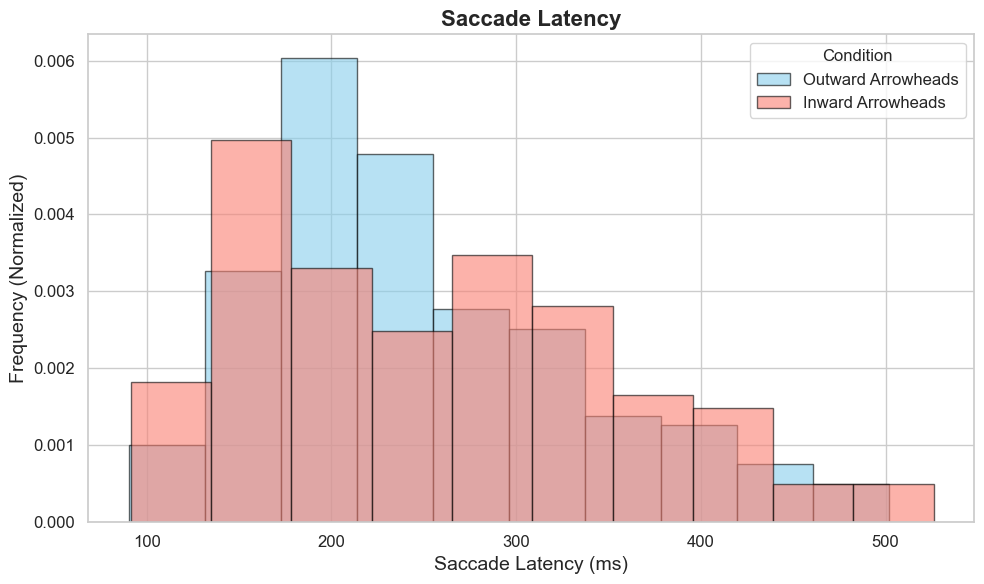

In [49]:
# Plot histograms with normalization
plt.figure(figsize=(10, 6))
sns.set_theme(style="whitegrid")

plt.title('Saccade Latency', fontsize=16, fontweight='bold')

outward = filtered_summary_df.SaccLat[summary_df.condition == 'arrowHeadsOutward']
inward = filtered_summary_df.SaccLat[summary_df.condition == 'arrowHeadsInward']

plt.hist(outward,  alpha=0.6, bins=10, label='Outward Arrowheads', density=True, color='skyblue', edgecolor='black')
plt.hist(inward,  alpha=0.6, bins=10, label='Inward Arrowheads', density=True, color='salmon', edgecolor='black')

plt.legend(title='Condition', fontsize=12)
plt.xlabel('Saccade Latency (ms)', fontsize=14)
plt.ylabel('Frequency (Normalized)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()